# 転移学習とファインチューニング

kerasには、すでに学習が済んでいる大規模なニューラルネットワークモデルを流用することができます。


+ **fine tuning**：学習済みモデルの重みを初期値にして、重みのみ再学習する
+ **転移学習**：学習済みモデルに、層を追加して、その層について学習する

Using TensorFlow backend.
c:\users\mio\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\mio\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\mio\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


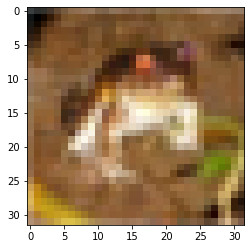

In [1]:
import keras
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# データの形式
print(
    X_train.shape,
    y_train.shape,
    X_test.shape,
    y_test.shape
)

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0])

In [2]:
# ベクトルからone hotに変換する
y_train = keras.utils.to_categorical(y_train,10)
y_test = keras.utils.to_categorical(y_test,10)

## 転移学習

In [4]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import optimizers
from keras import models
from keras import layers

# VGG16モデル
img_rows = 32
img_cols = 32
input_tensor = layers.Input(shape=(img_rows, img_cols, 3))
vgg16 = VGG16(
    include_top=False,      # ネットワークの出力層側にある3つの全結合層を含むかどうか
    weights='imagenet',      # None(ランダム初期化) 'imagenet'(ImageNetで学習した重み) 
    input_tensor=input_tensor# 入力層の形式
)

# 全結合層は自己学習モデル
model_ = Sequential()
model_.add(Flatten(input_shape=vgg16.output_shape[1:]))
model_.add(Dense(256, activation='relu'))
model_.add(Dropout(0.5))
model_.add(Dense(10, activation='softmax'))

# VGG16モデルと自己学習モデルの結合
model = models.Model(inputs=vgg16.input, outputs=model_(vgg16.output))

# modelの14層目までのモデル重み
for layer in model.layers[:15]:
    layer.trainable = False

# モデルの学習設定
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

# モデルの学習
result = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=30,
)

Epoch 1/30
50000/50000 [==============================] - 7s 148us/step - loss: 14.2140 - accuracy: 0.1009
Epoch 2/30
50000/50000 [==============================] - 7s 148us/step - loss: 14.5060 - accuracy: 0.1000
Epoch 3/30
50000/50000 [==============================] - 8s 153us/step - loss: 14.5063 - accuracy: 0.1000
Epoch 4/30
50000/50000 [==============================] - 8s 150us/step - loss: 14.5063 - accuracy: 0.1000
Epoch 5/30
50000/50000 [==============================] - 8s 152us/step - loss: 14.5059 - accuracy: 0.1000
Epoch 6/30
50000/50000 [==============================] - 8s 153us/step - loss: 14.5053 - accuracy: 0.0999
Epoch 7/30
50000/50000 [==============================] - 8s 152us/step - loss: 14.4991 - accuracy: 0.0994
Epoch 8/30
50000/50000 [==============================] - 8s 151us/step - loss: 14.5029 - accuracy: 0.1001
Epoch 9/30
50000/50000 [==============================] - 8s 151us/step - loss: 14.4917 - accuracy: 0.0998
Epoch 10/30
50000/50000 [============

In [5]:
# モデルの保存
model.save('./model/model_cnn.h5')

In [6]:
# テストデータへの適用
import numpy as np
y_predict = np.argmax(model.predict(X_test),axis=1)

In [7]:
# 正答率の算出
y_test = np.argmax(y_test,axis=1)
acc=np.sum(y_test==y_predict)/len(y_test)
print(acc)

0.7316


# 転移学習を行わなかった場合

In [8]:
# データ読み込み
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# ベクトルからone hotに変換する
y_train = keras.utils.to_categorical(y_train,10)
y_test = keras.utils.to_categorical(y_test,10)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers

# 基本モデル作成
model = Sequential()

# 3×3の畳み込み層の追加
model.add(
    Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation='relu',
    )
)

# 2×2のmaxプーリング層追加
model.add(
    MaxPooling2D(
        pool_size=(2, 2)
    )
)

# ドロップアウト層の追加
model.add(
    Dropout(0.2)
)

# フラット層の追加
model.add(
    Flatten()
)

# 全結合層の追加
model.add(
    Dense(
        128, 
        activation='relu'
    )
)

# ドロップアウト層の追加
model.add(
    Dropout(0.2)
)

# 出力層
model.add(
    Dense(
        10, 
        activation='softmax'
    )
)

In [10]:
# モデルの学習設定
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

In [11]:
# モデルの学習
result = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=100,
)

Epoch 1/100
50000/50000 [==============================] - 2s 41us/step - loss: 14.5040 - accuracy: 0.1000
Epoch 2/100
50000/50000 [==============================] - 2s 37us/step - loss: 14.5063 - accuracy: 0.1000
Epoch 3/100
50000/50000 [==============================] - 2s 38us/step - loss: 14.5063 - accuracy: 0.1000
Epoch 4/100
50000/50000 [==============================] - 2s 38us/step - loss: 14.5063 - accuracy: 0.1000
Epoch 5/100
50000/50000 [==============================] - 2s 38us/step - loss: 14.5063 - accuracy: 0.1000
Epoch 6/100
50000/50000 [==============================] - 2s 36us/step - loss: 14.5063 - accuracy: 0.1000
Epoch 7/100
50000/50000 [==============================] - 2s 37us/step - loss: 14.5065 - accuracy: 0.1000
Epoch 8/100
50000/50000 [==============================] - 2s 37us/step - loss: 14.5063 - accuracy: 0.1000
Epoch 9/100
50000/50000 [==============================] - 2s 37us/step - loss: 14.5063 - accuracy: 0.1000: 0s - loss: 14.5053 - accuracy: 0.1
E

50000/50000 [==============================] - 2s 37us/step - loss: 2.1171 - accuracy: 0.2354
Epoch 78/100
50000/50000 [==============================] - 2s 37us/step - loss: 1.9550 - accuracy: 0.2888
Epoch 79/100
50000/50000 [==============================] - 2s 36us/step - loss: 1.9170 - accuracy: 0.3046
Epoch 80/100
50000/50000 [==============================] - 2s 36us/step - loss: 1.8975 - accuracy: 0.3140
Epoch 81/100
50000/50000 [==============================] - 2s 36us/step - loss: 1.9159 - accuracy: 0.3062
Epoch 82/100
50000/50000 [==============================] - 2s 36us/step - loss: 1.8800 - accuracy: 0.3214
Epoch 83/100
50000/50000 [==============================] - 2s 36us/step - loss: 1.8765 - accuracy: 0.3216
Epoch 84/100
50000/50000 [==============================] - 2s 36us/step - loss: 1.8739 - accuracy: 0.3220
Epoch 85/100
50000/50000 [==============================] - 2s 36us/step - loss: 1.8465 - accuracy: 0.3321
Epoch 86/100
50000/50000 [========================

In [12]:
# モデル結果の出力
score = model.evaluate(X_test, y_test, verbose=0)
print(score)

[1.6735926139831543, 0.4072999954223633]
